In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, cohen_kappa_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from tensorflow.keras.layers import Dense, Flatten, Dropout


In [2]:
epochs = 15
learning_rate = 3.9e-5
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
folder_path = './../datasets/dataset1'
num_classes = 5
validation_split = 0.2
test_split = 0.2  # Proportion of the data to use for testing

# Load image file paths and their corresponding labels
image_paths = []
labels = []

class_names = sorted(os.listdir(folder_path))
class_indices = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(folder_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        image_paths.append(file_path)
        labels.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_split, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=validation_split, stratify=train_labels, random_state=42)

# Function to load and preprocess the images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0,1]
    label = tf.one_hot(label, num_classes)
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


In [5]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)


In [6]:

metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [7]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(epochs)

    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    
def show_confusion_matrix(model):
    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate classification report
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)

    # Plot confusion matrix
    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])

In [8]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Add custom top layers
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5 classes for diabetic retinopathy
model = Model(inputs=base_model.input, outputs=output)

In [9]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

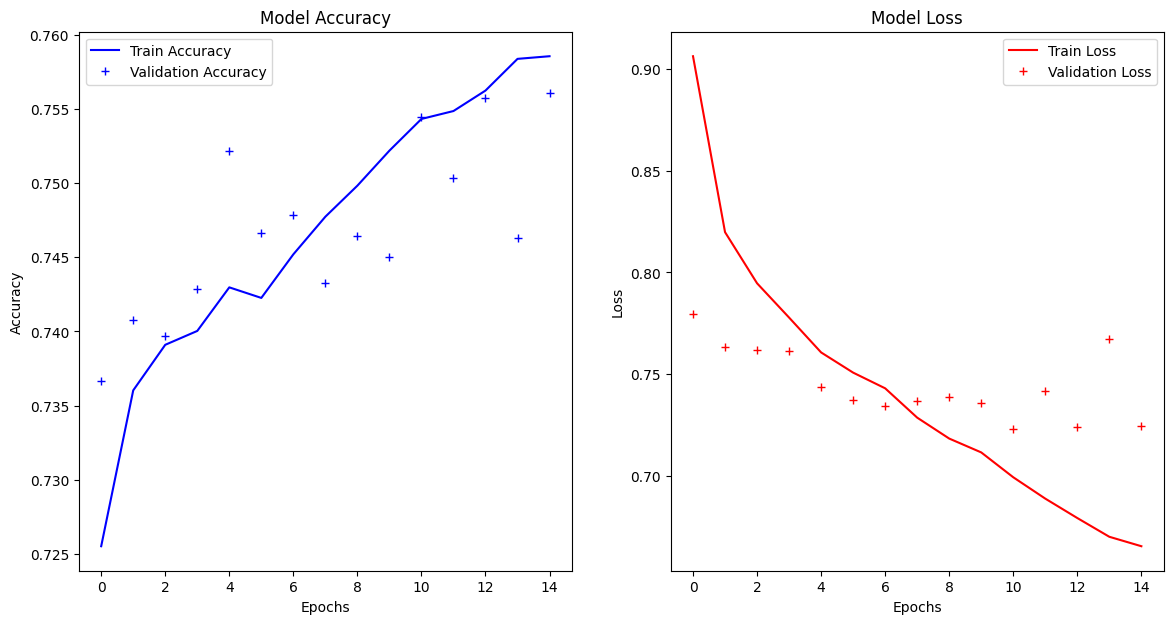

In [ ]:
accuracyGraph(history)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

           0       0.77      0.98      0.87      5162
           1       0.00      0.00      0.00       489
           2       0.45      0.17      0.24      1058
           3       1.00      0.01      0.01       175
           4       0.52      0.35      0.42       142

    accuracy                           0.75      7026
   macro avg       0.55      0.30      0.31      7026
weighted avg       0.67      0.75      0.68      7026

[[5059    1   84    0   18]
 [ 474    0   15    0    0]
 [ 862    0  177    0   19]
 [  88    0   77    1    9]
 [  49    0   43    0   50]]


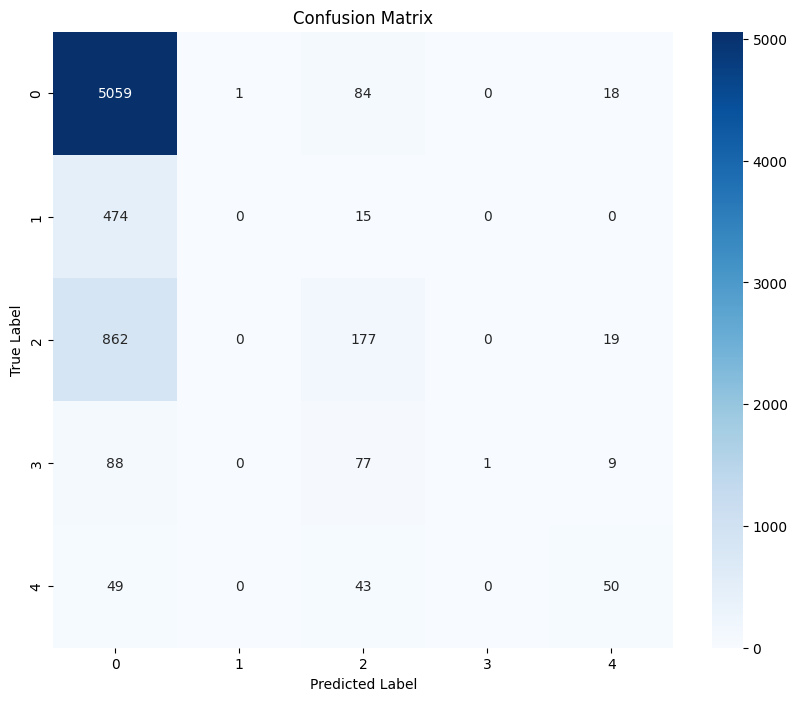

In [ ]:
show_confusion_matrix(model)

In [ ]:
warnings.filterwarnings('ignore', message="invalid value encountered in scalar divide")
_metrices = model.evaluate(test_dataset)
print("Test Metrices", _metrices)

220/220 [==============================] - 21s 94ms/step - loss: 0.7384 - accuracy: 0.7525 - auc: 0.9286 - balanced_accuracy: 0.3432 - fscore: 0.3193 - kappa_score: 0.1842 - precision: 0.7991 - recall: 0.6944
Test Metrices [0.7384223937988281, 0.752490758895874, 0.9286201596260071, 0.3432345986366272, 0.31932535767555237, 0.18416860699653625, 0.7990500926971436, 0.6944206953048706]


In [ ]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in model.layers[:379]:  # Adjust the index as needed
    layer.trainable = False
for layer in model.layers[379:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Epoch 1/15


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


703/703 [==============================] - 200s 234ms/step - loss: 0.7824 - accuracy: 0.7413 - auc: 0.9205 - balanced_accuracy: 0.3112 - fscore: 0.2843 - kappa_score: 0.1277 - precision: 0.7829 - recall: 0.6935 - val_loss: 0.7034 - val_accuracy: 0.7612 - val_auc: 0.9345 - val_balanced_accuracy: 0.3789 - val_fscore: 0.3470 - val_kappa_score: 0.2225 - val_precision: 0.7990 - val_recall: 0.7117
Epoch 2/15
703/703 [==============================] - 187s 235ms/step - loss: 0.6718 - accuracy: 0.7690 - auc: 0.9404 - balanced_accuracy: 0.4069 - fscore: 0.3807 - kappa_score: 0.2942 - precision: 0.8008 - recall: 0.7259 - val_loss: 0.6767 - val_accuracy: 0.7717 - val_auc: 0.9390 - val_balanced_accuracy: 0.4096 - val_fscore: 0.3842 - val_kappa_score: 0.2885 - val_precision: 0.8041 - val_recall: 0.7368
Epoch 3/15
703/703 [==============================] - 187s 236ms/step - loss: 0.5834 - accuracy: 0.7929 - auc: 0.9554 - balanced_accuracy: 0.4730 - fscore: 0.4476 - kappa_score: 0.4042 - precision: 0

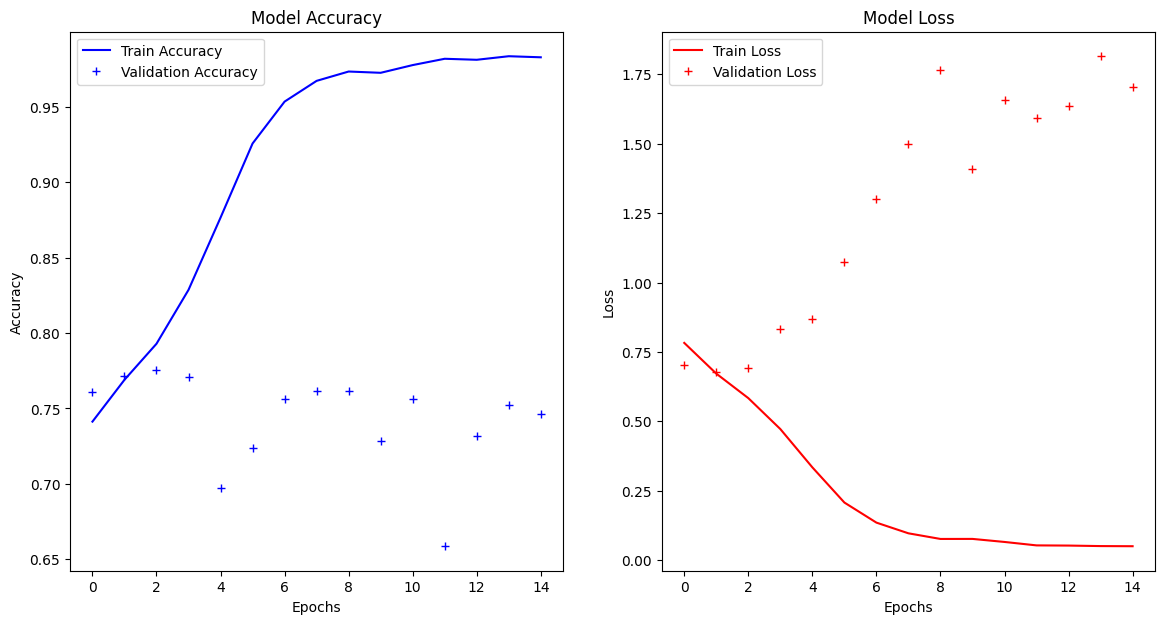

In [ ]:
accuracyGraph(history)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      5162
           1       0.16      0.08      0.10       489
           2       0.48      0.29      0.36      1058
           3       0.43      0.30      0.35       175
           4       0.45      0.56      0.50       142

    accuracy                           0.74      7026
   macro avg       0.47      0.43      0.44      7026
weighted avg       0.70      0.74      0.71      7026

[[4761  141  220    5   35]
 [ 420   37   30    0    2]
 [ 623   43  305   51   36]
 [  36    5   60   52   22]
 [  26    2   21   14   79]]


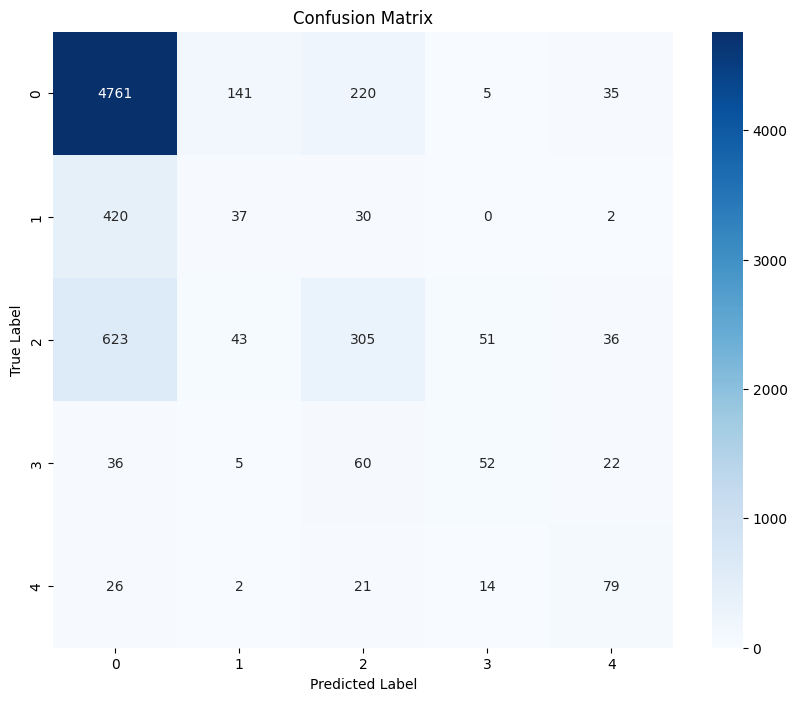

In [ ]:
show_confusion_matrix(model)

In [ ]:
_metrices = model.evaluate(test_dataset)
print("Test Metrices", _metrices)

220/220 [==============================] - 21s 96ms/step - loss: 1.7036 - accuracy: 0.7449 - auc: 0.8959 - balanced_accuracy: 0.4356 - fscore: 0.3917 - kappa_score: 0.2942 - precision: 0.7477 - recall: 0.7415
Test Metrices [1.7035531997680664, 0.7449473142623901, 0.8959347605705261, 0.4355826675891876, 0.39166104793548584, 0.29420003294944763, 0.7477037906646729, 0.7415314316749573]
